In [1]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv
from tqdm import tqdm
%matplotlib inline
import passion.util

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
models_folder_path = pathlib.Path('../../workflow/output/model')
old_rooftop_models_folder_path = models_folder_path / 'old-rooftop-segmentation'
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'

model_inria_aug_10e = torch.load(str(old_rooftop_models_folder_path / 'inria-aug-10e.pth'), map_location=torch.device(device))
model_inria_aug_5e = torch.load(str(old_rooftop_models_folder_path / 'inria-raw-10e.pth'), map_location=torch.device(device))
model_inria_raw_10e = torch.load(str(old_rooftop_models_folder_path / 'inria-aug-5e.pth'), map_location=torch.device(device))
model_inria_raw_5e = torch.load(str(old_rooftop_models_folder_path / 'inria-raw-5e.pth'), map_location=torch.device(device))

model_inria_final = torch.load(str(rooftop_models_folder_path / 'inria-aug-12e.pth'), map_location=torch.device(device))

In [4]:
inria_val_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/INRIA/output/val')
inria_val_folder_image = inria_val_folder / 'image'
inria_val_folder_label = inria_val_folder / 'label'

rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_segments_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

airs_test_path = pathlib.Path('/storage/internal/data/r-pueblas/airs/test')
airs_image_path = airs_test_path / 'image'
airs_label_path = airs_test_path / 'label'

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

In [6]:
def test_model_rooftops(model, test_folder, num_classes, background_class, ignore_index, output=True):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        if i>200: break

        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]

        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('aug_10e')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union
        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU: {np.mean(iou)}')
    
    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

def test_model_rid(model, test_folder, num_classes, rid_background_class, background_class, ignore_index, output=True):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
        
        label[label != rid_background_class] = 1
        label[label == rid_background_class] = 0

        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('aug_10e')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union
        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU: {np.mean(iou)}')
    
    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

def test_model_airs(model, test_folder, scale_percent, num_classes, background_class, ignore_index, output=True, n_samples=None):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)

    for i, filename in enumerate(test_folder_image.glob('*.tif')):
        if n_samples and (n_samples<=i): break
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dsize = (width, height)
        img = cv2.resize(image, dsize)
        label = cv2.resize(label, dsize)

        pred = prediction.segment_img(img, model, tile_size=512, stride=512, background_class=background_class)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        if i<5 and output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(pred)
            if i==0:
                axarr[0].title.set_text('Image')
                axarr[1].title.set_text('Ground truth')
                axarr[2].title.set_text('aug_10e')

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union
        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[~np.isnan(iou)])}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU: {np.mean(iou)}')
    
    return iou, np.mean(iou[~np.isnan(iou)]), elapsed_time

# Testing INRIA

In [7]:
num_classes = 2
background_class = 0
ignore_index = -1

In [8]:
print(f'Testing model inria_aug_10e...')

iou, mean_iou, elapsed_time = test_model_rooftops(model_inria_aug_10e,
                                                         inria_val_folder,
                                                         num_classes,
                                                         background_class,
                                                         ignore_index,
                                                         output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_10e...
Mean IoU: 0.847807326132997
IoU per class: [0.93641253 0.75920213]
Elapsed time: 118.40092921257019 seconds.


In [9]:
print(f'Testing model inria_raw_10e...')

iou, mean_iou, elapsed_time = test_model_rooftops(model_inria_raw_10e,
                                                         inria_val_folder,
                                                         num_classes,
                                                         background_class,
                                                         ignore_index,
                                                         output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_10e...
Mean IoU: 0.8235779210729894
IoU per class: [0.92629019 0.72086566]
Elapsed time: 120.66566753387451 seconds.


In [10]:
print(f'Testing model inria_aug_5e...')

iou, mean_iou, elapsed_time = test_model_rooftops(model_inria_aug_5e,
                                                         inria_val_folder,
                                                         num_classes,
                                                         background_class,
                                                         ignore_index,
                                                         output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_5e...
Mean IoU: 0.8465193867257228
IoU per class: [0.93559357 0.75744521]
Elapsed time: 116.85959482192993 seconds.


In [11]:
print(f'Testing model inria_raw_5e...')

iou, mean_iou, elapsed_time = test_model_rooftops(model_inria_raw_5e,
                                                         inria_val_folder,
                                                         num_classes,
                                                         background_class,
                                                         ignore_index,
                                                         output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_5e...
Mean IoU: 0.8162042423986741
IoU per class: [0.92407889 0.70832959]
Elapsed time: 111.60467028617859 seconds.


In [12]:
print(f'Testing final model...')

iou, mean_iou, elapsed_time = test_model_rooftops(model_inria_final,
                                                         inria_val_folder,
                                                         num_classes,
                                                         background_class,
                                                         ignore_index,
                                                         output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing final model...
Mean IoU: 0.8423346807146257
IoU per class: [0.93352786 0.7511415 ]
Elapsed time: 113.69226050376892 seconds.


# Testing RID

In [12]:
rid_background_class = 17

In [13]:
print(f'Testing model inria_aug_10e...')

iou, mean_iou, elapsed_time = test_model_rid(model_inria_aug_10e,
                                                  rid_test_folder,
                                                  num_classes,
                                                  rid_background_class,
                                                  background_class,
                                                  ignore_index,
                                                  output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_10e...
Mean IoU: 0.7617473792970644
IoU per class: [0.87887034 0.64462442]
Elapsed time: 137.18511533737183 seconds.


In [14]:
print(f'Testing model inria_raw_10e...')

iou, mean_iou, elapsed_time = test_model_rid(model_inria_raw_10e,
                                                  rid_test_folder,
                                                  num_classes,
                                                  rid_background_class,
                                                  background_class,
                                                  ignore_index,
                                                  output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_10e...
Mean IoU: 0.7661283942275854
IoU per class: [0.8793084  0.65294839]
Elapsed time: 135.04816675186157 seconds.


In [15]:
print(f'Testing model inria_aug_5e...')

iou, mean_iou, elapsed_time = test_model_rid(model_inria_aug_5e,
                                                  rid_test_folder,
                                                  num_classes,
                                                  rid_background_class,
                                                  background_class,
                                                  ignore_index,
                                                  output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_5e...
Mean IoU: 0.7662252473894691
IoU per class: [0.88480345 0.64764705]
Elapsed time: 143.93829226493835 seconds.


In [16]:
print(f'Testing model inria_raw_5e...')

iou, mean_iou, elapsed_time = test_model_rid(model_inria_raw_5e,
                                                  rid_test_folder,
                                                  num_classes,
                                                  rid_background_class,
                                                  background_class,
                                                  ignore_index,
                                                  output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_5e...
Mean IoU: 0.7763587105142358
IoU per class: [0.88934575 0.66337167]
Elapsed time: 139.5976917743683 seconds.


# AIRS

In [17]:
background_class = 0
num_classes = 2
scale_percent = 25

In [18]:
print(f'Testing model inria_aug_10e...')

iou, mean_iou, elapsed_time = test_model_airs(model_inria_aug_10e,
                                              airs_test_path,
                                              scale_percent,
                                              num_classes,
                                              background_class,
                                              ignore_index,
                                              output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_10e...
Mean IoU: 0.866490661102786
IoU per class: [0.9776904  0.75529092]
Elapsed time: 1617.1714451313019 seconds.


In [19]:
print(f'Testing model inria_raw_10e...')

iou, mean_iou, elapsed_time = test_model_airs(model_inria_raw_10e,
                                              airs_test_path,
                                              scale_percent,
                                              num_classes,
                                              background_class,
                                              ignore_index,
                                              output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_10e...
Mean IoU: 0.8465287582990798
IoU per class: [0.97347912 0.71957839]
Elapsed time: 1711.276927471161 seconds.


In [20]:
print(f'Testing model inria_aug_5e...')

iou, mean_iou, elapsed_time = test_model_airs(model_inria_aug_5e,
                                              airs_test_path,
                                              scale_percent,
                                              num_classes,
                                              background_class,
                                              ignore_index,
                                              output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_aug_5e...
Mean IoU: 0.7752117536901475
IoU per class: [0.95550337 0.59492014]
Elapsed time: 1640.1877014636993 seconds.


In [21]:
print(f'Testing model inria_raw_5e...')

iou, mean_iou, elapsed_time = test_model_airs(model_inria_raw_5e,
                                              airs_test_path,
                                              scale_percent,
                                              num_classes,
                                              background_class,
                                              ignore_index,
                                              output=False)

print(f'Mean IoU: {mean_iou}')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

Testing model inria_raw_5e...
Mean IoU: 0.7754282304151523
IoU per class: [0.95534785 0.59550861]
Elapsed time: 1637.2719938755035 seconds.


# Check optimal scale

In [8]:
print(f'Testing model inria_aug_10e...')

airs_gr = 0.075
grs = [2,1,0.75,0.5,0.4,0.3,0.2,0.1,0.075]
ious = []

for gr in grs:
    scale_percent = (airs_gr / gr) * 100
    print(f'Testing scale {scale_percent}%, gr {gr} m/pixel')
    iou, mean_iou, elapsed_time = test_model_airs(model_inria_aug_10e,
                                                  airs_test_path,
                                                  scale_percent,
                                                  num_classes,
                                                  background_class,
                                                  ignore_index,
                                                  output=False,
                                                  n_samples=10
                                                 )
    print(f'IoU: {iou}')
    ious.append(iou)

Testing model inria_aug_10e...
Testing scale 3.75%, gr 2 m/pixel
IoU: [0.92894031 0.09754744]
Testing scale 7.5%, gr 1 m/pixel
IoU: [0.92824647 0.22033324]
Testing scale 10.0%, gr 0.75 m/pixel
IoU: [0.94412707 0.39447996]
Testing scale 15.0%, gr 0.5 m/pixel
IoU: [0.96599575 0.62659586]
Testing scale 18.749999999999996%, gr 0.4 m/pixel
IoU: [0.97355512 0.70307351]
Testing scale 25.0%, gr 0.3 m/pixel
IoU: [0.97834271 0.75712884]
Testing scale 37.49999999999999%, gr 0.2 m/pixel
IoU: [0.97771722 0.75846735]
Testing scale 74.99999999999999%, gr 0.1 m/pixel
IoU: [0.95533154 0.61730839]
Testing scale 100.0%, gr 0.075 m/pixel
IoU: [0.95105443 0.59208684]


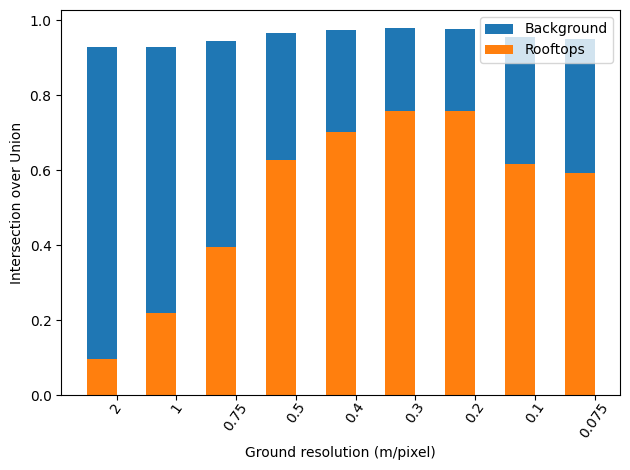

In [9]:
with plt.rc_context({"xtick.major.pad": 0}):
    fig, ax = plt.subplots()

    ious_np = np.array(ious)

    width = 0.5

    scales = list(range(len(grs)))
    ax.bar(np.array(scales) - (width / 2), ious_np[:,0], width=width, edgecolor="white", linewidth=0)
    ax.bar(np.array(scales) - (width / 2), ious_np[:,1], width=width, edgecolor="white", linewidth=0)

    ax.set_xticks(scales)
    ax.set_xticklabels(grs, rotation=55)
    
    ax.set_xlabel('Ground resolution (m/pixel)')
    ax.set_ylabel('Intersection over Union')
    ax.legend(['Background', 'Rooftops'])

    fig.tight_layout()
    plt.show()

# Testing Aachen

In [6]:
import pandas as pd
import geopandas as gpd
import shapely
import shapely.wkt
import shapely.ops
import utm
import rasterio
import numpy as np

import passion.segmentation

In [7]:
data_path = pathlib.Path('../data')
aachen_df = pd.read_csv(data_path / 'aachen_model.csv', index_col=0)

aachen_path = pathlib.Path('../../workflow/output/aachen-intersection-z19/satellite')

/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3433: DtypeWarning: Columns (1,4,5,9,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
print(f'There are {len(aachen_df)} polygons.')
aachen_df.head(2)

There are 496730 polygons.


,ST_AsText_1,ST_AsText_2,ST_SRID_1,Within,normal,area,tilt,azimuth,center,lon,lat,capacity,flat,elev,group,ID,poa,generation,gen
217008,"POLYGON Z ((293727.27 5628870.318 193.661,2937...",NaN,25832.0,True,[ 0. -0. 1.],45.969333,32.0,180.0,"[(293728.858683662, 5628871.637373464)]",6.074272,50.774872,2.442626,True,300.0,S2,217008.0,1.293567e+06,2426.687024,NaN
217013,"POLYGON Z ((293152.73 5628244.806 200.56,29315...",NaN,25832.0,True,[0. 0. 1.],36.064949,32.0,180.0,"[(293157.8567467185, 5628243.828399268)]",6.066537,50.769030,1.916347,True,300.0,S2,217013.0,1.291059e+06,1900.208815,NaN


In [9]:
aachen_df = aachen_df.dropna(subset=['ST_AsText_1'])

gs = gpd.GeoSeries.from_wkt(aachen_df['ST_AsText_1'])
aachen_gdf = gpd.GeoDataFrame(aachen_df, geometry=gs, crs="EPSG:4326")

In [10]:
def utm_to_latlon(x, y, z=None):
    aachen_utm_number, aachen_utm_letter = 32, 'U'
    return utm.to_latlon(x, y, aachen_utm_number, aachen_utm_letter)
aachen_gdf['polygon_latlon'] = aachen_gdf['geometry'].apply(lambda x: shapely.ops.transform(utm_to_latlon, x))
aachen_gdf = aachen_gdf.set_geometry('polygon_latlon')


def latlon_to_xy(x, y, z=None):
    zoom_level = 19
    return passion.util.gis.latlon_toXY(x, y, zoom_level)
aachen_gdf['polygon_xy'] = aachen_gdf['polygon_latlon'].apply(lambda x: shapely.ops.transform(latlon_to_xy, x))
aachen_gdf = aachen_gdf.set_geometry('polygon_xy')

In [11]:
# Randomly selected samples with significative amount of buildings
names = [
    '50D42M57338SNORTH_06D09M55075SEAST_19L.tif',
    '50D44M54530SNORTH_06D09M16451SEAST_19L.tif',
    '50D45M03541SNORTH_06D05M24709SEAST_19L.tif',
    '50D45M30572SNORTH_06D08M18516SEAST_19L.tif',
    '50D45M39582SNORTH_06D04M26773SEAST_19L.tif',
    '50D46M06607SNORTH_06D05M05397SEAST_19L.tif',
    '50D46M15615SNORTH_06D07M59204SEAST_19L.tif',
    '50D46M24622SNORTH_06D05M24709SEAST_19L.tif',
    '50D46M33628SNORTH_06D03M48149SEAST_19L.tif',
    '50D47M00645SNORTH_06D07M59204SEAST_19L.tif'
]

num_classes = 2

total_area_intersect = np.zeros((num_classes, ), dtype=float)
total_area_union = np.zeros((num_classes, ), dtype=float)
total_area_pred_label = np.zeros((num_classes, ), dtype=float)
total_area_label = np.zeros((num_classes, ), dtype=float)

for name in tqdm(names):
    img_path = aachen_path / name
    
    src = rasterio.open(img_path)
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    img = np.dstack((b,g,r))
    
    img_bbox = shapely.geometry.box(*src.bounds)
    
    img_gdf = aachen_gdf[aachen_gdf.geometry.intersects(img_bbox)]
    
    min_x, min_y = src.bounds[0], src.bounds[1]
    
    def rel_xy(x, y, z=None):
        return int(x-min_x), (y-min_y)
    
    img_gdf['rel_geometry'] = img_gdf.geometry.apply(lambda x: shapely.ops.transform(rel_xy, x))
    
    img_polygons = img_gdf['rel_geometry']
    img_classes = len(img_polygons) * [1]
    
    mask_img = passion.util.shapes.outlines_to_image(img_polygons, img_classes, img.shape)
    pred = passion.segmentation.prediction.segment_img(img, model_inria_aug_10e, tile_size=512, stride=512, background_class=0)
    
    area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(pred, mask_img, num_classes, -1)
    total_area_intersect += area_intersect
    total_area_union += area_union
    total_area_pred_label += area_pred_label
    total_area_label += area_label
    
    print(f'Partial iou: {total_area_intersect / total_area_union}')

  0%|                                                                          | 0/10 [00:00<?, ?it/s]/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 10%|██████▌                                                           | 1/10 [00:09<01:28,  9.82s/it]

Partial iou: [0.95619438 0.51945599]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 20%|█████████████▏                                                    | 2/10 [00:18<01:13,  9.23s/it]

Partial iou: [0.92758905 0.47043489]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 30%|███████████████████▊                                              | 3/10 [00:27<01:02,  8.86s/it]

Partial iou: [0.91690648 0.50165817]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 40%|██████████████████████████▍                                       | 4/10 [00:35<00:52,  8.71s/it]

Partial iou: [0.90315967 0.48762609]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 50%|█████████████████████████████████                                 | 5/10 [00:44<00:43,  8.74s/it]

Partial iou: [0.91224792 0.50109134]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 60%|███████████████████████████████████████▌                          | 6/10 [00:53<00:35,  8.87s/it]

Partial iou: [0.9002145  0.53057979]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 70%|██████████████████████████████████████████████▏                   | 7/10 [01:08<00:32, 10.89s/it]

Partial iou: [0.90697683 0.53347943]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 80%|████████████████████████████████████████████████████▊             | 8/10 [01:25<00:25, 12.81s/it]

Partial iou: [0.87838613 0.56476788]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
 90%|███████████████████████████████████████████████████████████▍      | 9/10 [01:47<00:15, 15.71s/it]

Partial iou: [0.87418055 0.54806715]


/storage/internal/home/r-pueblas/.conda/envs/passion-dev/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
100%|█████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.28s/it]

Partial iou: [0.87418337 0.54900534]


In [12]:
iou = total_area_intersect / total_area_union

print(f'IoU: {iou}. Mean: {np.mean(iou[~np.isnan(iou)])}')

IoU: [0.87418337 0.54900534]. Mean: 0.7115943554310994
